In [4]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

In [5]:
with open('order_dict.json') as f:
    data = json.load(f)

In [6]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [7]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [8]:
def r2_loss(outputs, targets):
    target_mean = torch.mean(targets)
    ss_tot = torch.sum((targets - target_mean) ** 2)
    ss_res = torch.sum((targets - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def r2_loss_2(outputs, targets):
    ss_tot = 0.0
    ss_res = 0.0
    target_mean = torch.mean(targets)
    for i in range(0,len(outputs)):
        ss_tot += (targets[i] - target_mean) ** 2
        ss_res += (targets[i] - outputs[i]) ** 2
    r2 = 1 - ss_res / ss_tot
    return r2

# TODO: need to work with tensor objects.
def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = 1000.0 / 31
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost
 
# print(torch.Tensor.float(1.0))
outputs = torch.randn(5)
targets = torch.randn(5)
# print(outputs.size())
# for i in range(0,len(outputs)):
#   print(2)
print(r2_loss(outputs,targets))
print(r2_loss_2(outputs,targets))
print(SPOLoss(outputs,targets))
# print(torch.randn(5))
# print(SPOLoss(1, 2))

tensor(-0.4622)
tensor(-0.4622)
tensor(4.8851)


In [9]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [10]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(epochs),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    #print("Train MSE =", MSE)
    #print('Train R^2 =', R2) 
    #print('Train SPO Loss =', SPO)
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO Loss Ave': SPO_mean})

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [19]:
import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    
    # return the best penalty coefficient that minimize average validation error
    start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 501
        grid = np.linspace(0,0.5,11) if regularize == 'l2' else np.linspace(0,1,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 301
        grid = np.linspace(3,4,6) if regularize == 'l2' else np.linspace(10,20,5)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(list(aveloss.keys()), list(aveloss.values()))
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    print('The best penalty coefficient is '+ str(best))
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    return best

In [20]:
x_train, y_train, x_test, y_test = preprocessing(order_dict[1])

In [21]:
# cross_validate(x_train, y_train, 'MSE', 'l2')

In [22]:
# cross_validate(x_train, y_train, 'MSE', 'l1')

In [23]:
# cross_validate(x_train, y_train, 'SPO', 'l2')

In [24]:
# cross_validate(x_train, y_train, 'SPO', 'l1')

## MSE loss models

### MSE loss model training

model trained using MSE loss
y-intercept  14.35352611541748
Coefficients  [[-0.48863095 -0.04419614 -0.1502745   0.4533145   1.3279471   0.20033066
  -0.98750275 -0.39758527  0.81625116  0.25489375  2.0823033   5.185167
  -0.5434937   0.29381374  6.006719    0.12529388  1.2124726  -1.4350771
  -1.868754    5.4087353   3.6848152   2.3873987   6.2338104  -6.4492016
  -0.55468667  2.7290862   0.03888672  0.7178609   0.35911843 -0.04477105
   0.4120008   2.2180295   0.7014337  -0.43085182 -0.36376944]]
Train MSE = 58.008868781190536
Train R^2 = 0.7638777133023117
Train SPO Loss = [2051.29580636]


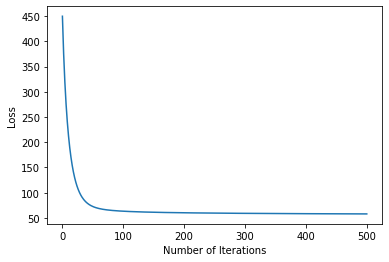

In [25]:
# ols model training

learningRate = 0.02
epochs = 501

model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None')

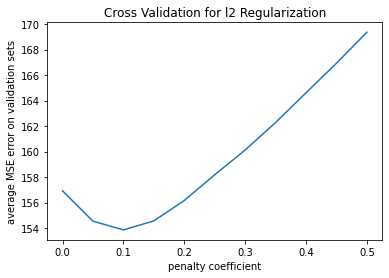

The best penalty coefficient is 0.1
Time:  10.424014915000043
model trained using MSE loss
y-intercept  13.670023918151855
Coefficients  [[-4.1244769e-01  4.8312028e-03 -1.6053857e-01  3.1213841e-01
   8.1432188e-01  2.7537271e-01 -5.4221624e-01 -5.9508008e-01
   9.7605985e-01  9.3115270e-02  1.6424037e+00  3.7442594e+00
  -5.0697035e-01  6.5202755e-01  5.6627569e+00 -1.8082651e-01
   1.3345256e+00 -1.1769563e+00 -1.6565046e+00  5.2100034e+00
   2.8401175e+00  1.8116795e+00  5.9676347e+00 -5.1506124e+00
  -7.7555376e-01  2.3690724e+00 -4.2615972e-02  4.6762630e-01
   1.9601804e-01 -3.8788445e-02  3.4517902e-01  2.1345108e+00
   6.2493598e-01 -4.2988545e-01 -3.7145314e-01]]
Train MSE = 60.25474542271147
Train R^2 = 0.7547359813675425
Train SPO Loss = [1925.81284748]


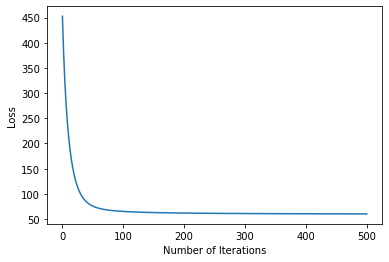

In [26]:
# ridge regression (l2 regrularization)

learningRate = 0.02
epochs = 501

# model training 

best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2')
model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2)

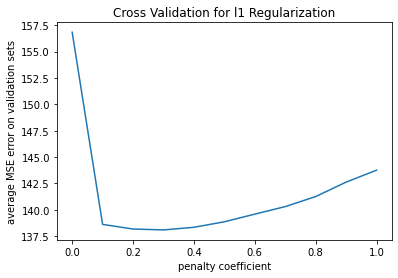

The best penalty coefficient is 0.30000000000000004
Time:  11.380854237999756
model trained using MSE loss
y-intercept  14.353525161743164
Coefficients  [[-1.24850348e-01  6.93725247e-04  7.06714066e-03  8.16506436e-05
   5.25085675e-03  1.86222062e-01 -5.87133737e-03 -3.85210484e-01
   1.08614707e+00 -5.78142877e-04  3.73534501e-01  3.82450008e+00
  -5.10944664e-01  3.70892316e-01  6.38455057e+00 -1.31223246e-01
   9.68349576e-01 -6.15920825e-03 -7.18029499e-01  5.69761419e+00
   3.08757806e+00  1.76673210e+00  6.34392214e+00 -5.09453154e+00
  -6.25346601e-01  1.98379993e+00 -1.20484205e-02  3.13530952e-01
   6.08115364e-03 -4.37015435e-03  1.91645220e-01  2.02209544e+00
   4.33031172e-01 -2.75988400e-01 -2.27718130e-01]]
Train MSE = 60.55370729567627
Train R^2 = 0.753519071564558
Train SPO Loss = [2050.54166582]


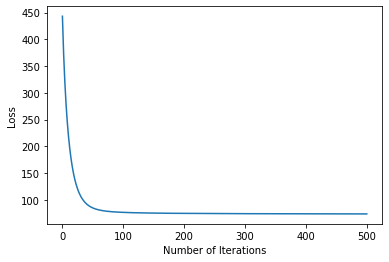

In [27]:
# l1 regularization (lasso) - penalty coefficient set to be 0.1

learningRate = 0.02
epochs = 501

best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1')
model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1)

### MSE loss model evaluation

In [28]:
# compile results for models trained on MSE loss
MSE_result = []

for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    MSE_result.append(pd.concat({name:score_df}))
    
MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])
MSE_scores

MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train  58.008869  0.763878  2051.295806     10.360080
          test   65.525871  0.595258   643.269276     11.285426
mse_ridge train  60.254745  0.754736  1925.812847      9.726328
          test   61.525895  0.619965   577.514785     10.131838
mse_lasso train  60.553707  0.753519  2050.541666     10.356271
          test   59.528556  0.632302   590.037089     10.351528

## SPO loss models

### SPO loss model training

model trained using SPO loss
y-intercept  8.559041976928711
Coefficients  [[ 2.15241507e-01  3.26013774e-01  4.61258292e-01  1.54747799e-01
   1.08631849e-01  2.50897165e-02  1.28948644e-01  1.02705255e-01
  -4.52895164e-02  3.37123930e-01  1.62728429e+00  2.03613186e+00
   1.58517495e-01  3.09587884e+00  1.88119614e+00 -3.95855963e-01
   2.33230090e+00 -1.08640301e+00 -1.25433064e+00  4.36805010e+00
   3.79406631e-01  1.10375595e+00  1.79567826e+00 -2.51020360e+00
  -2.87746549e-01  8.93319011e-01  2.61875391e-01  4.33057308e-01
  -3.02164610e-02 -4.80046198e-02  5.40271634e-04  3.09017897e-01
  -2.17084419e-02 -6.32509291e-01 -1.23448110e+00]]
Train MSE = 149.10630099747493
Train R^2 = 0.3930700340777269
Train SPO Loss = [1089.50631808]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


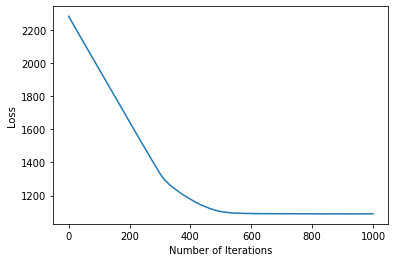

In [29]:
# ols

learningRate = 0.02
epochs = 1001

# model training
model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None')

model trained using SPO loss
y-intercept  8.424168586730957
Coefficients  [[ 1.03225792e-02 -1.38990611e-01  1.70388743e-01  1.90279379e-01
  -1.11777261e-01  2.22633965e-03  2.13653550e-01 -3.60436644e-03
   1.63447469e-01  3.94591466e-02  1.15903842e+00  1.21405780e+00
   8.55770111e-02  2.16764879e+00  1.92225480e+00 -5.52065074e-01
   2.03432536e+00 -7.50539660e-01 -1.15784657e+00  4.15796757e+00
   9.51091826e-01  1.00724626e+00  1.82394612e+00 -1.96671426e+00
  -4.90264475e-01  7.95129061e-01  3.00242275e-01  2.78658330e-01
   1.24979712e-01  1.78237587e-01  1.19103625e-01  3.52193713e-01
   1.78474665e-01 -5.56950450e-01 -8.94759774e-01]]
Train MSE = 154.8173431373964
Train R^2 = 0.3698235140569406
Train SPO Loss = [1109.25853818]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


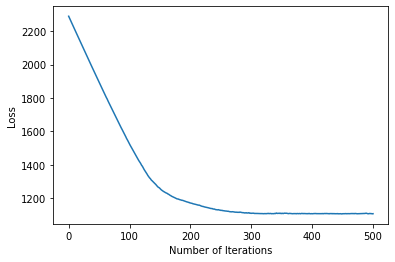

In [30]:
# ridge regression (l2 regrularization)

learningRate = 0.05
epochs = 501

# model training
best_l2_spo = 3.75
model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = best_l2_spo)

model trained using SPO loss
y-intercept  8.124090194702148
Coefficients  [[-5.3750752e-03  7.6310453e-04  1.0659522e-02  1.4776941e-01
  -2.4185376e-03  3.8078958e-03  1.3787784e-01 -3.0619267e-03
   4.3811706e-01  2.5250497e-03  1.3031125e-01  3.8810796e-04
   4.3297256e-04  2.8350942e+00  2.1754899e+00 -3.5069865e-01
   1.4208670e+00 -2.1773037e-03 -4.7176644e-01  4.6457300e+00
   1.7486347e-02 -1.6079503e-03  1.5015079e-02 -9.4066459e-01
  -3.6638296e-01  5.2302536e-03  3.0099761e-03 -3.4749354e-03
  -2.0442976e-02 -1.3279401e-03  2.2718248e-01  4.0713128e-02
   1.7260525e-01 -2.3638244e-01 -2.7361390e-01]]
Train MSE = 191.75457815567208
Train R^2 = 0.2194722905275962
Train SPO Loss = [1185.89204327]


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


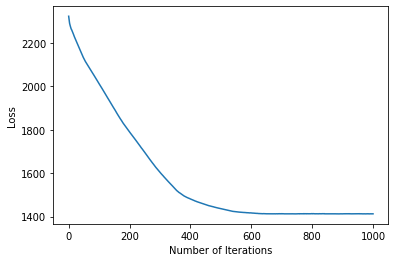

In [31]:
# l1 regularization (lasso)

learningRate = 0.02
epochs = 1001

best_l1_spo = 3.75
model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = 15)

### SPO loss model evaluation

In [32]:
# compile results for models trained on SPO loss
SPO_result = []

for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores

MSE       R^2     SPO Loss  SPO Loss Ave
spo_ols   train  149.106301  0.393070  1089.506318      5.502557
          test    98.417904  0.392089   404.333307      7.093567
spo_ridge train  154.817343  0.369824  1109.258538      5.602316
          test   100.135560  0.381480   388.491599      6.815642
spo_lasso train  191.754578  0.219472  1185.892043      5.989354
          test    99.015451  0.388398   352.158596      6.178221

In [33]:
MSE_scores

MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train  58.008869  0.763878  2051.295806     10.360080
          test   65.525871  0.595258   643.269276     11.285426
mse_ridge train  60.254745  0.754736  1925.812847      9.726328
          test   61.525895  0.619965   577.514785     10.131838
mse_lasso train  60.553707  0.753519  2050.541666     10.356271
          test   59.528556  0.632302   590.037089     10.351528

# References

In [34]:
%%script false --no-raise-error
import time
# Batch Gradient Descent Using Numpy - For comparison purpose

"""
code is based on Yuhan Cheng's code, approved use
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    alpha = 0.0
    beta = np.zeros((xvalue_matrix.shape[1],))
    epsilon = 0.00001
    n = float(len(xvalue_matrix))
    loss = []
    for i in range(MaxIterations):
        # compute new coefficients
        y_pred = alpha + np.matmul(xvalue_matrix, beta)
        loss.append(mean_squared_error(y_pred,yvalues))
#         if i % 100 == 0:
#             print('Current Loss:', loss)
        d_alpha = np.mean(y_pred - yvalues)
        d_beta = np.mean((y_pred - yvalues) * xvalue_matrix.T, axis = 1)
        alpha_1 = alpha - (R * d_alpha)
        beta_1 = beta - (R * d_beta)
        
        if np.isnan(alpha_1):
            print('nan at iter', str(i))
            break
        
        # check to see whether stopping criteria has been met
        if (np.abs(alpha_1-alpha)<epsilon) and np.all(np.abs(beta_1-beta)<epsilon):
            alpha, beta = alpha_1, beta_1
            print('error < epsilon, criteria met')
            break
        alpha, beta = alpha_1, beta_1
            
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print('MSE:', str(loss[-1]))
    print('R2:', str(r2_score(y_true=yvalues, y_pred = y_pred)))
    
    plt.plot(range(len(loss)),loss)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    return alpha, beta

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
